In [22]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense, Dropout
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras.regularizers import l2
import cv2
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn import metrics
from collections import Counter 
from IPython.display import clear_output

In [4]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def get_siamese_model(input_shape, similarity_metric='l1', verbose=True):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
#     model = Sequential()
#     model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape,
#                     kernel_initializer=initialize_weights, 
#                     kernel_regularizer=l2(2e-4)))
    
#     model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
#                     kernel_initializer=initialize_weights, 
#                     kernel_regularizer=l2(2e-4)))    
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Dropout(0.25))
#     model.add(Flatten())
    
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.25))
    
#     model.add(Dense(input_shape[0]**2, activation='sigmoid', kernel_initializer=initialize_weights,
#                     bias_initializer=initialize_bias, 
#                     kernel_regularizer=l2(1e-3),))
    
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    if similarity_metric == 'l1':
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))        
    elif siamese_metric == 'l2':
        Similarity_layer = Lambda(lambda tensors:K.sqrt(K.square(tensors[0] - tensors[1])))
    elif siamese_metric == 'cross': ## TODO
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))     
        
    Similarity_distance = Similarity_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(Similarity_distance)
    
    # Connect the input with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    if verbose:
        model.summary()
    return siamese_net

In [5]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [66]:
class Siamese_Loader:
    def __init__(self, train_path=None, 
                 test_path=None, dataset_type = '49kmnist',
                 images=None, labels=None, img_channel=1):
        """
        Loads dataset
        
        Parameters
        -----------
        
        train_path ... list[train_images, train_labels]
        test_path ... list[test_images, test_labels]
        
        """
        self.train_images = []
        self.train_labels = []
        self.train_path = train_path
        
        self.test_images = []
        self.test_labels = []        
        self.test_path = test_path
        
        self.dataset_type = dataset_type        
        
        if train_path is None and test_path is None:
            self.train_images = images[0]
            self.train_labels = labels[0]
            self.test_images = images[1]
            self.test_labels = labels[1] 
        
        else:        
            print('Loading Train images')
            self.train_images = self._load(self.train_path[0])

            print('Loading Test images')
            self.test_images = self._load(self.test_path[0])

            print('Loading Train labels')
            self.train_labels = self._load(self.train_path[1])

            print('Loading Test labels')
            self.test_labels = self._load(self.test_path[1])

        self.train_n_classes = len(np.unique(self.train_labels))
        self.test_n_classes = len(np.unique(self.test_labels))
        
        self.train_shape = self.train_images[0].shape
        self.test_shape = self.test_images[0].shape
        
        self.image_channel = img_channel
        
    def _load(self, f):
        return np.load(f)['arr_0']
        
    def _get_index(self, labels, i, images):
        while True:
            idx = np.random.randint(0, len(images))
            if labels[idx] == i:
                return idx, labels[idx]
            
    def _get_false_index(self, labels, i, images):
        while True:
            idx = np.random.randint(0, len(images))
            if labels[idx] != i:
                return idx, labels[idx]
            
    def get_batch(self, batch_multiplier = 1, disable_progress_bar = False):
        
        if type(batch_multiplier) is float:
            raise TypeError('batch_multiplier must be an integer')
        
        n_examples = batch_multiplier*self.train_n_classes
        
        img_shape = self.train_images[0].shape
        pairs = [np.zeros((n_examples, img_shape[0], img_shape[1], self.image_channel)) for i in range(2)]
        targets = []
        
        images = self.train_images
        labels = self.train_labels
        n_classes = self.train_n_classes
        
        k = 0
        for i in tqdm_notebook(range(0, n_examples), disable = disable_progress_bar):
            img_1 = None
            img_2 = None
            
            i_correto = i % n_classes            
            
            if i%2 == 0: 
                idx_1, categ_1 = self._get_index(labels, i_correto, images)
                img_1 = self.train_images[idx_1]
                idx_2, categ_2 = self._get_index(labels, i_correto, images)
                img_2 = images[idx_2]
                target = 1
                
            else:
                idx_1, categ_1 = self._get_index(labels, i_correto, images)
                img_1 = self.train_images[idx_1]
                idx_2, categ_2 = self._get_false_index(labels, i_correto, images)
                img_2 = images[idx_2]
                target = 0

            
            pairs[0][k] = img_1.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
            pairs[1][k] = img_2.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
            targets.append(target)
            k += 1
            
        pairs[0] /= 255.
        pairs[1] /= 255.
        
        return pairs, targets
                    
        
    def one_shot_task(self, N = 49, tipo = 'train'):
        """
        Create a set of pairs, targets for N-way one shot learning.
        """
        if tipo == 'train':
            images = self.train_images
            labels = self.train_labels
            n_classes = self.train_n_classes
        else:
            images = self.test_images
            labels = self.test_labels
            n_classes = self.test_n_classes
            
        
        img_shape = images[0].shape
        pairs = [np.zeros((N, img_shape[0], img_shape[1], self.image_channel)) for i in range(2)]
        targets = []
        k = 0
        
        i_sorteado = np.random.randint(0,n_classes)
        idx_base, categ_base = self._get_index(labels, i_sorteado, images)
        img_base = images[idx_base]

        idx_pair, categ_pair = self._get_index(labels, i_sorteado, images)
        img_pair = images[idx_pair]
        
        pairs[0][k] = img_base.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
        pairs[1][k] = img_pair.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
        targets.append(1)
        
        for j in range(1, N):
            
            idx_pair, categ_pair = self._get_false_index(labels, i_sorteado, images)
            img_pair = images[idx_pair]

            if categ_base == categ_pair:
                targets.append(1)
            else:
                targets.append(0)
            
            k += 1
            pairs[0][k] = img_base.reshape((self.train_shape[0],self.train_shape[1],self.image_channel))
            pairs[1][k] = img_pair.reshape((self.train_shape[0],self.train_shape[1],self.image_channel))

            
        
        pairs[0] /= 255.
        pairs[1] /= 255.
        
        return pairs, targets
    
    def test_oneshot(self, model, N, k, verbose=True, tipo = 'test'):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.one_shot_task(N, tipo = tipo)
            probs = model.predict(inputs)
            probs = 1-probs
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct

In [31]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(ref, comparativas, x_s = 28, y_s = 28):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(ref.reshape(x_s,y_s), cmap='gray')
    img = concat_images(comparativas)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
for i in tqdm_notebook(range(0,10), disable = False):
    pass

In [ ]:
# batch_size = 128
# num_classes = 10
# epochs = 12

In [ ]:
# def load(f):
#     return np.load(f)['arr_0']

In [ ]:
# Load the data
# x_train = load('dataset/kuzushiji-mnist/k49-train-imgs.npz')
# x_test = load('dataset/kuzushiji-mnist/k49-test-imgs.npz')
# y_train = load('dataset/kuzushiji-mnist/k49-train-labels.npz')
# y_test = load('dataset/kuzushiji-mnist/k49-test-labels.npz')

In [ ]:
# ys = list()
# for y in y_train:
#     if y not in ys:
#         ys.append(y)
# print('N classes: {}'.format(len(ys)))
# print(len(Counter(y_train).keys()))
# np.unique(y_train, return_counts=True)

In [ ]:
w = x_train[99]

plt.imshow(w, cmap="gray")

plt.show()

# Model

In [ ]:
model = get_siamese_model((28, 28, 1), verbose=True)
model.compile(loss=contrastive_loss,optimizer=Adam(lr = 0.00006))
# model.compile(loss=contrastive_loss,optimizer=Adadelta())
# model.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.00006))
model.summary()

## Loading dataset

In [ ]:
loader = Siamese_Loader(train_path=['dataset/kuzushiji-mnist/k49-train-imgs.npz',
                                    'dataset/kuzushiji-mnist/k49-train-labels.npz'],
                       test_path=['dataset/kuzushiji-mnist/k49-test-imgs.npz',
                                  'dataset/kuzushiji-mnist/k49-test-labels.npz'])

In [ ]:
#train_pairs, train_targets = loader.get_batch(batch_multiplier=2)

In [ ]:
N = 10
test_pairs, test_targets = loader.one_shot_task(N=N, tipo='test')
print(test_targets)

plot_oneshot_task(test_pairs[0][9], test_pairs[1][:N])

# Training pipeline 1

In [ ]:
evaluate = 100 # interval for evaluating on one-shot tasks and losses
batch_multiplier = 4
n_iter = 2000 # 20000
best = -1
N_way = 10
data_path = 'kmodel_weights/'
weights_path_2 = 'kmodel_weights/kmodel_weights_1.h5'

In [ ]:
print("Starting training process!")
print("##############################################################")
t_start = time.time()
for i in tqdm_notebook(range(1, n_iter)):
    
    inputs, targets = loader.get_batch(batch_multiplier, disable_progress_bar=True)
    
    loss=model.train_on_batch(inputs,targets)
    
    if i % evaluate == 0:
        clear_output()
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,20,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path_2))
            model.save_weights(weights_path_2)
            best=val_acc   
    
        print("iteration {}, training loss: {:.2f},".format(i,loss))
        print('---------------------------------------------------------------------------------')

        
# weights_path_2 = os.path.join(data_path, "model_weights.h5")
# model.load_weights(weights_path_2)

# Training pipeline 2

In [ ]:
model.fit(x=train_pairs, y=train_targets, epochs=2000) 

In [ ]:
weight_path_fit = 'kmodel_weights/model_weights_2_10.h5'
model.save_weights(weight_path_fit)

In [ ]:
len(test_pairs[0])

In [ ]:
N = 10
test_pairs, test_targets = loader.one_shot_task(N=N, tipo='test')
plot_oneshot_task(test_pairs[0][9], test_pairs[1][:N])

In [ ]:
predict = model.predict(x=test_pairs)
predict

In [ ]:
# fpr, tpr, thresholds = metrics.roc_curve(test_targets, predict)
# metrics.auc(fpr, tpr)

# omniglot

In [8]:
#!pip install scipy==1.1.0

In [2]:
from load_data import *

loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(hiragana)


In [9]:
data_path = os.path.join('dataset/omniglot')
train_folder = os.path.join(data_path,'images_train')
valpath = os.path.join(data_path,'images_test')

In [10]:
with open(os.path.join(data_path, "pickle/train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "pickle/val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Japanese_(hiragana)']
Validation alphabets:

['Japanese_(hiragana)']


In [14]:
x_train = []
y_train = []
x_test = []
y_test = []

target = 0
for classe in X:    
    for img in classe:
        x_train.append(img)
        y_train.append(target)
    target += 1

target = 0
for classe in Xval:    
    for img in classe:
        x_test.append(img)
        y_test.append(target)
    target += 1    

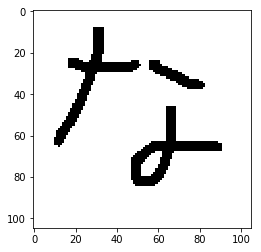

In [15]:
plt.imshow(x_train[0], cmap='gray')

plt.show()

In [16]:
x_imgs = np.asarray([np.asarray(x_train), np.asarray(x_test)])
y_lbls = np.asarray([np.asarray(y_train), np.asarray(y_test)])

In [19]:
x_imgs[0].shape

(780, 105, 105)

In [72]:
omni_loader = Siamese_Loader(images = x_imgs, labels=y_lbls, dataset_type='omniglot_hiragana')

In [73]:
omni_loader.dataset_type

'omniglot_hiragana'

In [118]:
model_hiragana = get_siamese_model((105, 105, 1), verbose=False)
model_hiragana.compile(loss=contrastive_loss,optimizer=Adam(lr = 0.00006))
# model.compile(loss=contrastive_loss,optimizer=Adadelta())
# model.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.00006))
model_hiragana.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 4096)         38947648    input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 4096)         0           sequential_8[1][0]               
          

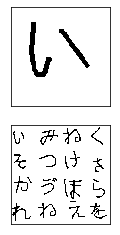

In [75]:
N = 16
test_pairs, test_targets = omni_loader.one_shot_task(N=N, tipo='test')

plot_oneshot_task(test_pairs[0][9], test_pairs[1][:N], x_s=105, y_s=105)

In [119]:
evaluate = 100 # interval for evaluating on one-shot tasks and losses
batch_multiplier = 4
n_iter = 600 # 20000
best = -1
N_way = 10
data_path = 'kmodel_weights/'
weights_path_2 = 'kmodel_weights/omni_model_hiragana_weights_1.h5'

In [120]:
print("Starting training process!")
print("##############################################################")
t_start = time.time()
for i in tqdm_notebook(range(1, n_iter)):
    
    inputs, targets = omni_loader.get_batch(batch_multiplier, disable_progress_bar=True)
    
    loss=model_hiragana.train_on_batch(inputs,targets)
    
    if i % evaluate == 0:
        clear_output()
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = omni_loader.test_oneshot(model_hiragana,N_way,1,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path_2))
            model_hiragana.save_weights(weights_path_2)
            best=val_acc   
    
        print("iteration {}, training loss: {:.2f},".format(i,loss))
        print('---------------------------------------------------------------------------------')

Time for 500 iterations: 167.83492922782898
Evaluating model on 1 random 10 way one-shot learning tasks ... 

Got an average of 100.0% 10 way one-shot learning accuracy 

Current best: 100.0, previous best: 100.0
Saving weights to: kmodel_weights/omni_model_hiragana_weights_1.h5 

iteration 500, training loss: 0.18,
---------------------------------------------------------------------------------


In [34]:
inputs, targets = omni_loader.get_batch(batch_multiplier, disable_progress_bar=True)
# inputs, targets = loader.get_batch(batch_multiplier, disable_progress_bar=True)

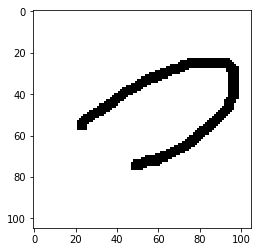

In [43]:
plt.imshow(inputs[0][2].reshape((105,105)), cmap='gray')

plt.show()

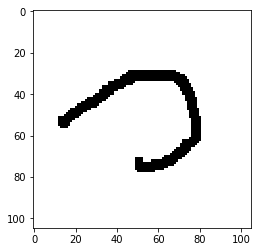

In [44]:
plt.imshow(inputs[1][2].reshape((105,105)), cmap='gray')

plt.show()

In [40]:
print(targets)

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [55]:
p = model_hiragana.predict(inputs)
print(p)

[[0.07819474]
 [0.9530854 ]
 [0.00471979]
 [0.99907255]
 [0.04967433]
 [0.9995208 ]
 [0.14416355]
 [0.99980664]
 [0.07096747]
 [0.9995147 ]
 [0.02558032]
 [0.9999473 ]
 [0.00893933]
 [0.99999523]
 [0.01011994]
 [0.9999938 ]
 [0.04875603]
 [0.9111043 ]
 [0.0675894 ]
 [0.9869051 ]
 [0.01314721]
 [0.9986696 ]
 [0.20201814]
 [0.99978113]
 [0.13327274]
 [0.9999932 ]
 [0.03907815]
 [0.99993205]
 [0.07820347]
 [0.999329  ]
 [0.05746487]
 [0.9934052 ]
 [0.6195356 ]
 [0.9999873 ]
 [0.07284221]
 [0.9917108 ]
 [0.01084524]
 [0.90852106]
 [0.08468094]
 [0.9413328 ]
 [0.08053303]
 [0.95314986]
 [0.0828864 ]
 [0.9473704 ]
 [0.6195356 ]
 [0.9575542 ]
 [0.03507495]
 [0.9985305 ]
 [0.09593564]
 [0.99667823]
 [0.01655519]
 [0.99528897]
 [0.6195356 ]
 [0.94656044]
 [0.04084885]
 [0.999748  ]
 [0.11611375]
 [0.8384712 ]
 [0.06497297]
 [0.9999058 ]
 [0.03461832]
 [0.9456352 ]
 [0.6195356 ]
 [0.9999484 ]
 [0.12096438]
 [0.9999871 ]
 [0.01392686]
 [0.99985325]
 [0.01762906]
 [0.98819435]
 [0.07451889]
 [0.99

In [123]:
x_t, y_t = omni_loader.one_shot_task(N=20, tipo='test')

In [124]:
print(y_t)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


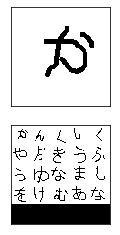

In [125]:
plot_oneshot_task(x_t[0][0], x_t[1], x_s=105, y_s=105)

In [126]:
predict = model_hiragana.predict(x_t)
print(np.argmin(predict))

0


In [122]:
correct = 0
n = 100
for i in tqdm_notebook(range(0, n)):
    x_t, y_t = omni_loader.one_shot_task(N=20, tipo='test')
    predict = model_hiragana.predict(x_t)
    if np.argmin(predict) == 0:
        correct += 1
print('Acuracia: {}%'.format((correct/n)*100))  

Acuracia: 39.0%
